In [99]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

2.1

In [3]:
ILI = pd.read_csv('ILINet.csv')

In [139]:
def weeknum(year,week):
    if year in long_year:
        if week <= 20:
            wknm = week+14
        else:
            wknm = week - 39
    else:
        if week <= 20:
            wknm = week + 13
        else:
            wknm = week - 39
    return int(wknm)

def write_season(year,week):
    if week <= 20:
        start = year-1
        end = year
        season = str(start)+'-'+str(end)
        return season
    elif week >= 40:
        start = year
        end = year+1
        season = str(start)+'-'+str(end)
        return season

In [140]:
#subset ILI to contain years after 2000 and only select specific region and region type during epiweeks
ILI_sub = ILI.loc[(ILI['YEAR'] >= 2000) & (ILI['REGION TYPE'] == 'National')&(ILI['REGION'] == 'X')][['YEAR','WEEK','% WEIGHTED ILI']]
ILI_sub = ILI_sub.loc[(ILI['WEEK'] <= 20) | (ILI['WEEK'] >= 40)]
#determine which years are long years
long_year = ILI_sub.loc[ILI_sub['WEEK'] == 53][['YEAR']]['YEAR'].values.tolist()
short_year = ILI_sub['YEAR'].values.tolist()
short_year = list(set(short_year).symmetric_difference(set(long_year)))
#Find the epiweek num from week num
ILI_sub['epiweek']=ILI_sub[['YEAR','WEEK']].apply(lambda x: weeknum(x.YEAR, x.WEEK), axis=1)
#This half year belongs to next season
drop = ILI_sub[(ILI_sub['YEAR'] == 2000)&(ILI_sub['epiweek']>13)].index
ILI_sub.drop(drop,inplace=True)
#Write the season notation to the df
ILI_sub['season'] = ILI_sub[['YEAR','WEEK']].apply(lambda x: write_season(x.YEAR, x.WEEK), axis=1)


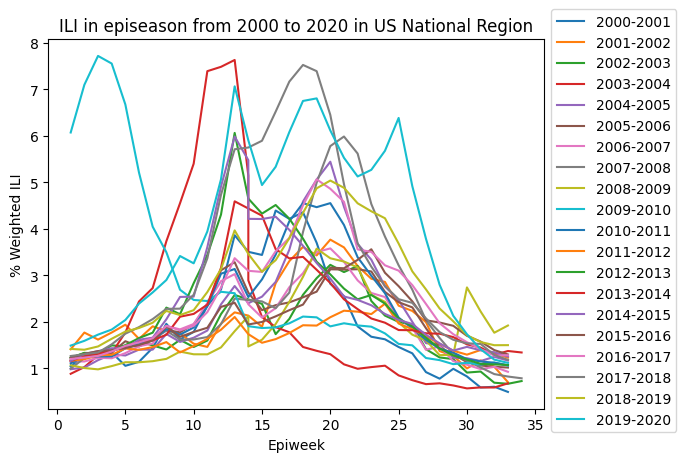

In [72]:
for season in ILI_sub['season'].unique():
    temp = ILI_sub.loc[ILI_sub['season'] == season]
    week = temp['epiweek']
    weighted_ILI = temp['% WEIGHTED ILI']
    plt.plot(week,weighted_ILI,label = season)
plt.title('ILI in episeason from 2000 to 2020 in US National Region')
plt.xlabel('Epiweek')
plt.ylabel('% Weighted ILI')
legend=plt.legend(bbox_to_anchor=(1, 1.1))
plt.savefig('2.1.png')

2.2

In [189]:
def gaussian(df):
    hist, bins = np.histogram(df)
    bin_centres = (bins[:-1] + bins[1:])/2
    mean = sum(bin_centres*hist)/sum(hist)                  
    sigma = sum(hist*(bin_centres-mean)**2)/sum(hist)
    return mean,sigma

In [178]:
def epiweek_mean_sigma(df):
    test= df.loc[df['season'] == '2019-2020']
    train= df.loc[df['season'] != '2019-2020']
    newtable = pd.DataFrame({'epiweek': pd.Series(dtype='int'),
                   'Mean': pd.Series(dtype='float'),
                   'Sigma': pd.Series(dtype='float')})
    idx = 0
    for epiweek in train['epiweek'].unique():
        temp = train.loc[train['epiweek'] == epiweek]
        mean,sigma = gaussian(temp['% WEIGHTED ILI'])
        newline = [epiweek, mean, sigma]
        newtable.loc[idx] = newline
        idx += 1
    return newtable,test

In [179]:
ILI_22,test=epiweek_mean_sigma(ILI_sub)
ILI_22.to_csv('2.2.csv')
ILI_22

,epiweek,Mean,Sigma
0,1.0,1.443478,1.084393
1,2.0,1.632290,1.496486
2,3.0,1.635244,1.832382
3,4.0,1.716731,1.707388
4,5.0,1.720515,1.263182
5,6.0,1.785668,0.662310
6,7.0,1.801155,0.350299
7,8.0,2.049177,0.358150
8,9.0,2.009601,0.436141
9,10.0,2.154724,0.694272


2.3

In [116]:
def detect_anomaly(x):
    if (x['% WEIGHTED ILI'] < (x['Mean'] - 3 * x['Sigma'])) or (x['% WEIGHTED ILI'] > (x['Mean'] + 3 * x['Sigma'])):
        return 'anomaly'
    else:
        return 'normal'

In [180]:
#merge the two df to compare two columns
ILI_23=pd.merge(test, ILI_22, on='epiweek', how='inner')
ILI_23['anomaly'] = ILI_23.apply (lambda x: detect_anomaly(x), axis=1)
anomaly_list = list(ILI_23[ILI_23['anomaly']=='anomaly']['epiweek'])
print("these weeks are anomaly: ", anomaly_list)

these weeks are anomaly:  [9, 23, 24, 25, 26, 27, 28, 29]


2.4

These week very much make sense, because we can see from 2.1 graph. 2019-2020 is very different from all other curves. It is most likely due to COVID-19 outbreak. Covid19 has flu symptoms and add anomality to the data. These weeks correspond to the 2.1 graph very well, indicating the weeks where covid 19 play a very important part.

2.5

In [181]:
def make_newdf(regiontype, region):
    ILI_sub = ILI.loc[(ILI['YEAR'] >= 2000) & (ILI['REGION TYPE'] == regiontype)&(ILI['REGION'] == region)][['YEAR','WEEK','% WEIGHTED ILI']]
    ILI_sub = ILI_sub.loc[(ILI['WEEK'] <= 20) | (ILI['WEEK'] >= 40)]

    ILI_sub['epiweek']=ILI_sub[['YEAR','WEEK']].apply(lambda x: weeknum(x.YEAR, x.WEEK), axis=1)

    drop = ILI_sub[(ILI_sub['YEAR'] == 2000)&(ILI_sub['epiweek']>13)].index
    ILI_sub.drop(drop,inplace=True)

    ILI_sub['season'] = ILI_sub[['YEAR','WEEK']].apply(lambda x: write_season(x.YEAR, x.WEEK), axis=1)
    return ILI_sub

In [182]:
def output_anomaly(region):
    df = make_newdf('HHS Regions',region)
    ILI_temp,test=epiweek_mean_sigma(df)
    ILI_new = pd.merge(test, ILI_temp, on='epiweek', how='inner')
    ILI_new['anomaly'] = ILI_new.apply (lambda x: detect_anomaly(x), axis=1)
    anomaly_list = list(ILI_new[ILI_new['anomaly']=='anomaly']['epiweek'])
    print("these weeks are anomaly: ", anomaly_list)

In [184]:
output_anomaly('Region 2')

these weeks are anomaly:  [9, 24, 25, 26, 27, 28, 29, 30]


In [185]:
output_anomaly('Region 4')

these weeks are anomaly:  [6, 7, 8, 9, 24, 25, 26, 27, 28, 29]


In [186]:
output_anomaly('Region 7')

these weeks are anomaly:  [24, 25, 26, 27, 31]


In [187]:
output_anomaly('Region 9')

these weeks are anomaly:  [25]


In [188]:
output_anomaly('Region 10')

these weeks are anomaly:  [12, 13, 25, 28]
